In [1]:

import antigranular as ag
session = ag.login("yveemYmiUV93QmAJlwv3dQ9DvbISuTrJ", "CadbiOM3+dIU+7rfUIPCryYNtN92xLC0UovJA65/z394+l6dInUBrlueleJlqpEF", dataset = "Iris Dataset")

C:\Users\taori\Desktop\users\AntigranularClient\antigranular\client.py:143: UserWarning: Antigranular client version 0.2.14 not in supported clients list shared by the server, please update antigranular client to the latest version.
  warnings.warn(


Output: Dataset "Iris Dataset" loaded to the kernel as iris_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      

Connected to Antigranular server session id: db33c706-192e-42de-b593-3026a0373d75, the session will time out if idle for 26 minutes
Cell magic '%%ag' registered successfully, use `%%ag` in a notebook cell to execute your python code on Antigranular private python server
🚀 Everything's set up and ready to roll!


**Loading the Dataset**

In [2]:
%%ag
from ag_utils import export , load_dataset
import pandas as pd
from op_pandas import PrivateDataFrame


In [3]:
%%ag
x = load_dataset("Iris Dataset")
train_x = x["train_x"]
train_y = x["train_y"]
test_x = x["test_x"]

Dataset "Iris Dataset" loaded to the kernel as iris_dataset
Key Name                       Value Type     
---------------------------------------------
train_x                        PrivateDataFrame
train_y                        PrivateDataFrame
test_x                         DataFrame      



In [4]:
%%ag
export(train_x.describe(eps=0.1) , 'result')

Setting up exported variable in local environment: result


In [5]:
result

,sepal_length,sepal_width,petal_length,petal_width
count,0.000000,0.000000,0.000000,0.000000
mean,7.000000,5.000000,7.000000,3.500000
std,2.034588,0.733955,1.177773,1.310789
min,2.000000,2.300000,2.000000,0.500000
25%,4.402233,3.483588,3.055946,0.877395
50%,6.802341,3.042306,2.882884,1.076072
75%,6.351144,3.385906,5.992492,2.086440
max,4.310577,3.920763,3.850581,1.540646


**Using Applymap**

In [6]:
%%ag

# encoding categoricals
def func_(x:str)-> int:
  if x == 'Iris-setosa':
    return 0
  elif x == 'Iris-versicolor':
    return 1
  else: # Iris-virginica
    return 2

train_y_encoded = train_y.applymap(func_ , output_bounds={'species':(0,2)})

In [7]:
%%ag
train_data = train_x.join(train_y_encoded , how="left")
export(train_data.describe(eps=0.5) , 'result')

Setting up exported variable in local environment: result


In [8]:
result

,sepal_length,sepal_width,petal_length,petal_width,species
count,52.000000,52.000000,52.000000,52.000000,52.000000
mean,2.606691,4.795982,2.000000,3.500000,0.000000
std,2.082178,0.674698,1.330597,1.317978,0.874821
min,2.000000,2.300000,2.000000,0.500000,0.000000
25%,4.972414,3.143916,4.456632,0.505388,0.000000
50%,5.146968,4.215499,4.285688,2.163826,0.782332
75%,5.303558,2.625251,3.647000,2.190367,0.369766
max,6.137191,3.736983,6.057657,2.417093,1.452644


**Exploring data using snsql**

In [9]:
%%ag
import op_snsql

/usr/local/lib/python3.10/site-packages/opendp/typing.py:28: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  np.bool8: 'bool',  # np.bool_



In [10]:
%%ag
privacy = op_snsql.Privacy(epsilon=1.0)
reader = op_snsql.from_df(df=train_y_encoded, privacy=privacy)

In [11]:
%%ag
# get idea about expected privacy_cost that will be spent.
total_cost = reader.get_privacy_cost([
    "SELECT COUNT(species) as setosa from df.table WHERE species == 0",
    "SELECT COUNT(species) as versicolor from df.table WHERE species == 1",
    "SELECT COUNT(species) as virginica from df.table WHERE species == 2"
    ])
export(str(total_cost) , "total_cost")

Setting up exported variable in local environment: total_cost


In [12]:
total_cost # (epsilon , delta)

'(6.0, 3.552713678800501e-15)'

In [13]:
%%ag
# execute returns in the following format -> [[column_names] , [values]]
c0 = reader.execute("SELECT COUNT(species) as setosa from df.table WHERE species == 0")
c1 = reader.execute("SELECT COUNT(species) as versicolor from df.table WHERE species == 1")
c2 = reader.execute("SELECT COUNT(species) as virginica from df.table WHERE species == 2")

export(str([c0,c1,c2]) , 'counts')

Setting up exported variable in local environment: counts


In [14]:
count_data = eval(counts)
col , count = [i[0][0] for i in count_data] , [i[1][0] for i in count_data]
print(f"col = {col} , count = {count}")

col = ['setosa', 'versicolor', 'virginica'] , count = [42, 42, 39]


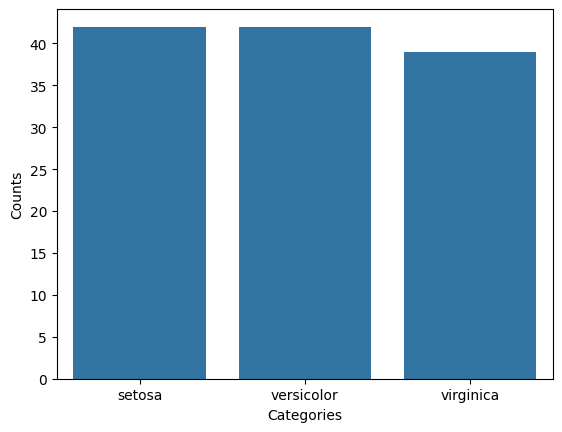

In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(x=col , y=count)
plt.xlabel('Categories')
plt.ylabel('Counts')
plt.show()

**Evaluating correlation of the columns**

In [16]:
%%ag
priv_corr = train_x.corr(eps=7)
export(priv_corr , 'priv_corr')

Setting up exported variable in local environment: priv_corr


<Axes: >

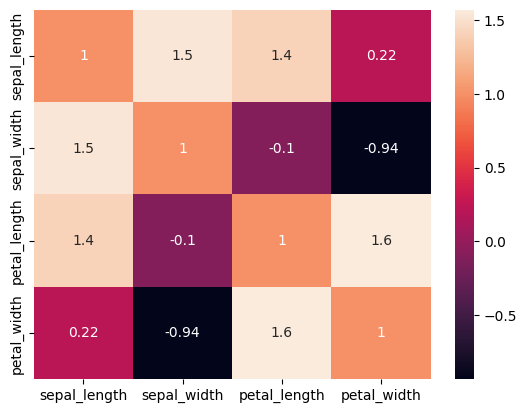

In [17]:
import pandas as pd
result = priv_corr.apply(pd.to_numeric, errors='coerce').astype(float)
sns.heatmap(result , annot = True)

**Implementing RandomForestClassier using diffprivlib**

In [18]:
%%ag
from op_diffprivlib.models import RandomForestClassifier
l_meta, r_meta = [], []
for l,r in train_x.metadata.values():
  l_meta.append(l)
  r_meta.append(r)
bounds = ( l_meta , r_meta ) # ([lower] , [upper])
model = RandomForestClassifier(n_estimators=100, epsilon = 1.0 , random_state=0 , bounds=bounds , classes=['Iris-setosa','Iris-versicolor','Iris-virginica'])

In [19]:
%%ag
model.fit(train_x,train_y)

/usr/local/lib/python3.10/site-packages/sklearn/utils/validation.py:1183: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)



In [20]:
%%ag
Y = model.predict(test_x)
export(Y , "output_y")

Setting up exported variable in local environment: output_y


In [21]:
output_y

array(['Iris-versicolor', 'Iris-virginica', 'Iris-setosa', 'Iris-setosa',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-versicolor', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa',
       'Iris-setosa', 'Iris-versicolor', 'Iris-setosa', 'Iris-versicolor',
       'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-versicolor',
       'Iris-setosa', 'Iris-setosa', 'Iris-versicolor', 'Iris-setosa',
       'Iris-versicolor', 'Iris-setosa', 'Iris-setosa', 'Iris-setosa'],
      dtype='<U15')

In [22]:
y_df = pd.DataFrame(output_y)
result = session.submit_predictions(y_df)
print(result)

{'score': {'leaderboard': 0, 'logs': {}}}


In [23]:
# Privacy budget spent
session.privacy_odometer()

{'total_epsilon_used': 13.6,
 'total_delta_used': 4.6629367034256575e-15,
 'library_costs': None,
 'dataset_costs': None}

In [24]:
session.terminate_session()

{'status': 'ok'}